# Plot and comparisons

In [1]:
library(tidyverse)
library(ggpubr)

-- Attaching packages ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.2     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



## Functions

In [2]:
save_plot <- function(p, fn, w=7, h=6){
    for(ext in c(".pdf", ".png", ".svg")){
        ggsave(filename=paste0(fn,ext), plot=p, width=w, height=h)
    }
}


get_metrics <- function(fn, model, label){
    dt = data.table::fread(fn) %>% as.data.frame %>% mutate_if(is.character, as.factor) %>%
        mutate_at("fold", as.character) %>% 
        select(tissue, feature, fold, n_features, starts_with("test_score_r2")) %>%
        pivot_longer(-c(tissue, feature, fold), names_to="metric", values_to="score") %>%
        group_by(tissue, feature, metric) %>%
        summarise(Mean=mean(score), Median=median(score), Std=sd(score), .groups = "keep") %>%
        filter(metric == "test_score_r2") %>% mutate("model"=model) %>% mutate(Type = label)
    return(dt)
}

## Genetic variation prediction for expression of ancestry DE genes and random genes

### Load data

In [3]:
top100 = data.table::fread("../../../_m/degs_annotation.txt") %>% 
    group_by(Tissue) %>% mutate(rank = row_number(adj.P.Val)) %>% 
    filter(rank <= 100) %>% select(V1, ensemblID, gene_name, Tissue) %>% 
    distinct %>% rename("Feature"="V1") %>% rename("tissue"="Tissue")

#### Annotate and merge data

In [4]:
dtu = data.table::fread(paste0("../../../../differential_analysis/tissue_comparison/",
                               "ds_summary/_m/diffSplicing_ancestry_FDR05_4regions.tsv")) %>%
    select(gene, Tissue) %>% distinct %>% rename("gene_name"="gene")

degs = data.table::fread("../../../_m/degs_annotation.txt") %>%
    select(V1, ensemblID, gene_name, Tissue) %>% distinct %>%
    rename("Feature"="V1") %>% inner_join(dtu, by=c("Tissue", "gene_name")) %>%
    rename("tissue"="Tissue") %>% mutate("DTU"="DTU")

random = data.table::fread("../../../_m/randomGenes_annotation.txt") %>%
    select(V1, ensemblID, gene_name, Tissue) %>% distinct %>%
    rename("Feature"="V1") %>% inner_join(dtu, by=c("Tissue", "gene_name")) %>%
    rename("tissue"="Tissue") %>% mutate("DTU"="DTU")

#### DE genes

In [5]:
rf = get_metrics("../../de_genes/rf/summary_10Folds_allTissues.tsv", "Random Forest", "DE")
enet = get_metrics("../../de_genes/enet/summary_10Folds_allTissues.tsv", "Elastic Net", "DE")
de = bind_rows(rf, enet) %>% mutate(Feature=gsub("_", ".", feature)) %>%
    left_join(degs, by=c("tissue", "Feature")) %>% as.data.frame %>%
    mutate(New_Type = paste(Type, replace_na(DTU, ""))) %>%
    mutate_if(is.character, as.factor)
de %>% head
de$Type %>% unique

,tissue,feature,metric,Mean,Median,Std,model,Type,Feature,ensemblID,gene_name,DTU,New_Type
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,Caudate,ENSG00000003249_13,test_score_r2,-0.002856899,0.03781765,0.1982073,Random Forest,DE,ENSG00000003249.13,NA,NA,NA,DE
2,Caudate,ENSG00000003509_15,test_score_r2,-0.128148560,-0.06360597,0.1504515,Random Forest,DE,ENSG00000003509.15,NA,NA,NA,DE
3,Caudate,ENSG00000004468_12,test_score_r2,-0.198605136,-0.09842729,0.1881863,Random Forest,DE,ENSG00000004468.12,NA,NA,NA,DE
4,Caudate,ENSG00000004777_18,test_score_r2,-0.344985568,-0.25373680,0.4829072,Random Forest,DE,ENSG00000004777.18,NA,NA,NA,DE
5,Caudate,ENSG00000005243_9,test_score_r2,-0.248017098,-0.21435654,0.2968836,Random Forest,DE,ENSG00000005243.9,NA,NA,NA,DE
6,Caudate,ENSG00000005436_13,test_score_r2,0.126125017,0.13625009,0.1663395,Random Forest,DE,ENSG00000005436.13,ENSG00000005436,GCFC2,DTU,DE DTU


[1] DE
Levels: DE

#### Top 100 DE genes

In [6]:
de100 = bind_rows(rf, enet) %>% mutate(Feature=gsub("_", ".", feature)) %>% 
    inner_join(top100, by=c("tissue", "Feature"))
de100 %>% dim

[1] 764  11

#### Random genes

In [7]:
rf = get_metrics("../../random_genes/rf/summary_10Folds_allTissues.tsv", 
                     "Random Forest", "Random")
enet = get_metrics("../../random_genes/enet/summary_10Folds_allTissues.tsv", 
                       "Elastic Net", "Random")
rand = bind_rows(rf, enet)%>% mutate(Feature=gsub("_", ".", feature)) %>%
    left_join(random, by=c("tissue", "Feature")) %>% as.data.frame %>%
    mutate(New_Type = paste(Type, replace_na(DTU, ""))) %>%
    mutate_if(is.character, as.factor)
rand %>% head
rand$Type %>% unique

,tissue,feature,metric,Mean,Median,Std,model,Type,Feature,ensemblID,gene_name,DTU,New_Type
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,Caudate,ENSG00000001084_10,test_score_r2,-0.10568232,-0.09784934,0.1329299,Random Forest,Random,ENSG00000001084.10,NA,NA,NA,Random
2,Caudate,ENSG00000001630_15,test_score_r2,-0.18184880,-0.11087436,0.2012179,Random Forest,Random,ENSG00000001630.15,NA,NA,NA,Random
3,Caudate,ENSG00000002587_9,test_score_r2,-0.16901411,-0.08722611,0.2458042,Random Forest,Random,ENSG00000002587.9,NA,NA,NA,Random
4,Caudate,ENSG00000002933_7,test_score_r2,-0.07044221,-0.03925164,0.1650651,Random Forest,Random,ENSG00000002933.7,NA,NA,NA,Random
5,Caudate,ENSG00000003393_14,test_score_r2,-0.19319686,-0.14058706,0.2751248,Random Forest,Random,ENSG00000003393.14,NA,NA,NA,Random
6,Caudate,ENSG00000003400_14,test_score_r2,-0.11172415,-0.08874340,0.1617553,Random Forest,Random,ENSG00000003400.14,NA,NA,NA,Random


[1] Random
Levels: Random

#### Merge data

In [8]:
df = bind_rows(de, rand)
dim(df)
df %>% head(2)
df$Type %>% unique

[1] 37468    13

,tissue,feature,metric,Mean,Median,Std,model,Type,Feature,ensemblID,gene_name,DTU,New_Type
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,Caudate,ENSG00000003249_13,test_score_r2,-0.002856899,0.03781765,0.1982073,Random Forest,DE,ENSG00000003249.13,NA,NA,NA,DE
2,Caudate,ENSG00000003509_15,test_score_r2,-0.128148560,-0.06360597,0.1504515,Random Forest,DE,ENSG00000003509.15,NA,NA,NA,DE


[1] DE     Random
Levels: DE Random

### Summarize

In [9]:
df %>% group_by(tissue, Type, model) %>% 
    summarise(Mean=mean(Median), Median=median(Median), .groups = "keep") 

tissue,Type,model,Mean,Median
<fct>,<fct>,<fct>,<dbl>,<dbl>
Caudate,DE,Elastic Net,0.046824293,-0.01074297
Caudate,DE,Random Forest,-0.003779483,-0.04764570
Caudate,Random,Elastic Net,-0.031713741,-0.03899560
Caudate,Random,Random Forest,-0.096066770,-0.09682914
DLPFC,DE,Elastic Net,0.043382091,-0.01427053
DLPFC,DE,Random Forest,-0.015966827,-0.05965098
DLPFC,Random,Elastic Net,-0.049235705,-0.05156694
DLPFC,Random,Random Forest,-0.130636227,-0.12972883
Dentate Gyrus,DE,Elastic Net,-0.042714190,-0.07105638


In [10]:
df %>% group_by(tissue, Type, model) %>% 
    summarise(Mean=mean(Median), Median=median(Median), .groups = "keep") %>%
    filter(model == "Elastic Net")

tissue,Type,model,Mean,Median
<fct>,<fct>,<fct>,<dbl>,<dbl>
Caudate,DE,Elastic Net,0.04682429,-0.01074297
Caudate,Random,Elastic Net,-0.03171374,-0.03899560
DLPFC,DE,Elastic Net,0.04338209,-0.01427053
DLPFC,Random,Elastic Net,-0.04923571,-0.05156694
Dentate Gyrus,DE,Elastic Net,-0.04271419,-0.07105638
Dentate Gyrus,Random,Elastic Net,-0.14183646,-0.12442962
Hippocampus,DE,Elastic Net,0.03062896,-0.01784020
Hippocampus,Random,Elastic Net,-0.03806728,-0.03998911


In [11]:
df %>% group_by(tissue, Type, model) %>% 
    summarise(Mean=mean(Median), Median=median(Median), .groups = "keep") %>%
    filter(model == "Random Forest")

tissue,Type,model,Mean,Median
<fct>,<fct>,<fct>,<dbl>,<dbl>
Caudate,DE,Random Forest,-0.003779483,-0.04764570
Caudate,Random,Random Forest,-0.096066770,-0.09682914
DLPFC,DE,Random Forest,-0.015966827,-0.05965098
DLPFC,Random,Random Forest,-0.130636227,-0.12972883
Dentate Gyrus,DE,Random Forest,-0.109158980,-0.13368794
Dentate Gyrus,Random,Random Forest,-0.321247001,-0.31566815
Hippocampus,DE,Random Forest,-0.024028727,-0.05773127
Hippocampus,Random,Random Forest,-0.105771529,-0.10358206


In [13]:
df %>% filter(DTU == "DTU") %>% group_by(tissue, New_Type, model) %>% 
    summarise(Mean=mean(Median), Median=median(Median), .groups = "keep")

tissue,New_Type,model,Mean,Median
<fct>,<fct>,<fct>,<dbl>,<dbl>
Caudate,DE DTU,Elastic Net,0.081422714,0.01311672
Caudate,DE DTU,Random Forest,0.033633330,-0.02671328
Caudate,Random DTU,Elastic Net,-0.042723875,-0.04345409
Caudate,Random DTU,Random Forest,-0.110650265,-0.09868582
DLPFC,DE DTU,Elastic Net,0.113791408,0.03734998
DLPFC,DE DTU,Random Forest,0.062114999,-0.01159725
DLPFC,Random DTU,Elastic Net,-0.032211432,-0.04758998
DLPFC,Random DTU,Random Forest,-0.104759586,-0.12445701
Dentate Gyrus,DE DTU,Elastic Net,0.005700645,-0.07592577


In [14]:
df %>% filter(DTU == "DTU") %>% group_by(tissue, New_Type, model) %>% 
    summarise(Mean=mean(Median), Median=median(Median), .groups = "keep") %>%
    filter(model == "Elastic Net")

tissue,New_Type,model,Mean,Median
<fct>,<fct>,<fct>,<dbl>,<dbl>
Caudate,DE DTU,Elastic Net,0.081422714,0.01311672
Caudate,Random DTU,Elastic Net,-0.042723875,-0.04345409
DLPFC,DE DTU,Elastic Net,0.113791408,0.03734998
DLPFC,Random DTU,Elastic Net,-0.032211432,-0.04758998
Dentate Gyrus,DE DTU,Elastic Net,0.005700645,-0.07592577
Dentate Gyrus,Random DTU,Elastic Net,-0.124886491,-0.09891128
Hippocampus,DE DTU,Elastic Net,0.087471515,0.01387694
Hippocampus,Random DTU,Elastic Net,-0.027494227,-0.03365646


In [19]:
de100 %>% group_by(tissue, model) %>% 
    summarise(Mean=mean(Median), .groups = "keep") %>% as.data.frame %>%
    pivot_wider(names_from="model", values_from="Mean")

tissue,Elastic Net,Random Forest
<chr>,<dbl>,<dbl>
Caudate,0.2283147,0.19525370
DLPFC,0.2610151,0.21962943
Dentate Gyrus,0.1031959,0.08820506
Hippocampus,0.2452457,0.19171992


In [20]:
de100 %>% group_by(tissue, model) %>% 
    summarise(Median=median(Median), .groups = "keep") %>% as.data.frame %>%
    pivot_wider(names_from="model", values_from="Median")

tissue,Elastic Net,Random Forest
<chr>,<dbl>,<dbl>
Caudate,0.21095822,0.1600187
DLPFC,0.23666764,0.1924569
Dentate Gyrus,0.08515138,0.0644140
Hippocampus,0.19743658,0.1490395


#### Test if DE genes are significant more predictive than random genes

In [12]:
for(tissue in c("Caudate", "Dentate Gyrus", "DLPFC", "Hippocampus")){
    xx = de %>% filter(tissue == tissue)
    yy = rand %>% filter(tissue == tissue)
    tt = t.test(xx$Median, yy$Median, alternative = "greater")$p.value
    print(tt)
}

[1] 0
[1] 0
[1] 0
[1] 0


In [13]:
df %>% group_by(tissue) %>% 
    do(fit = broom::tidy(lm(Median ~ Type, data=.))) %>%
    unnest(fit) %>% filter(term != '(Intercept)') %>%
    mutate(p.bonf = p.adjust(p.value, "bonf"))

tissue,term,estimate,std.error,statistic,p.value,p.bonf
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Caudate,TypeRandom,-0.08541266,0.002645699,-32.28359,3.751268e-219,1.500507e-218
DLPFC,TypeRandom,-0.10364360,0.002945424,-35.18801,5.020572e-257,2.008229e-256
Dentate Gyrus,TypeRandom,-0.15560514,0.007755310,-20.06434,2.680821e-84,1.072329e-83
Hippocampus,TypeRandom,-0.07521952,0.002425112,-31.01693,4.660740e-203,1.864296e-202


In [14]:
df %>% filter(Type == "DE") %>% group_by(tissue) %>% 
    do(fit = broom::tidy(lm(Median ~ New_Type, data=.))) %>%
    unnest(fit) %>% filter(term != '(Intercept)') %>%
    mutate(p.bonf = p.adjust(p.value, "bonf"))

tissue,term,estimate,std.error,statistic,p.value,p.bonf
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Caudate,New_TypeDE DTU,0.04130844,0.006818805,6.058018,1.463818e-09,5.855270e-09
DLPFC,New_TypeDE DTU,0.08152278,0.008870552,9.190271,5.468858e-20,2.187543e-19
Dentate Gyrus,New_TypeDE DTU,0.06459084,0.026013145,2.483008,1.313335e-02,5.253339e-02
Hippocampus,New_TypeDE DTU,0.06360128,0.008007479,7.942734,2.356165e-15,9.424662e-15


In [15]:
df %>% filter(Type == "Random") %>% group_by(tissue) %>% 
    do(fit = broom::tidy(lm(Median ~ New_Type, data=.))) %>%
    unnest(fit) %>% filter(term != '(Intercept)') %>%
    mutate(p.bonf = p.adjust(p.value, "bonf"))

tissue,term,estimate,std.error,statistic,p.value,p.bonf
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Caudate,New_TypeRandom DTU,-0.01356067,0.005795044,-2.340045,0.019314599,0.07725840
DLPFC,New_TypeRandom DTU,0.02228672,0.007857250,2.836452,0.004578489,0.01831396
Dentate Gyrus,New_TypeRandom DTU,0.03810179,0.033865163,1.125103,0.260718748,1.00000000
Hippocampus,New_TypeRandom DTU,0.01540211,0.006287738,2.449547,0.014332596,0.05733038


### Plot

#### Boxplots

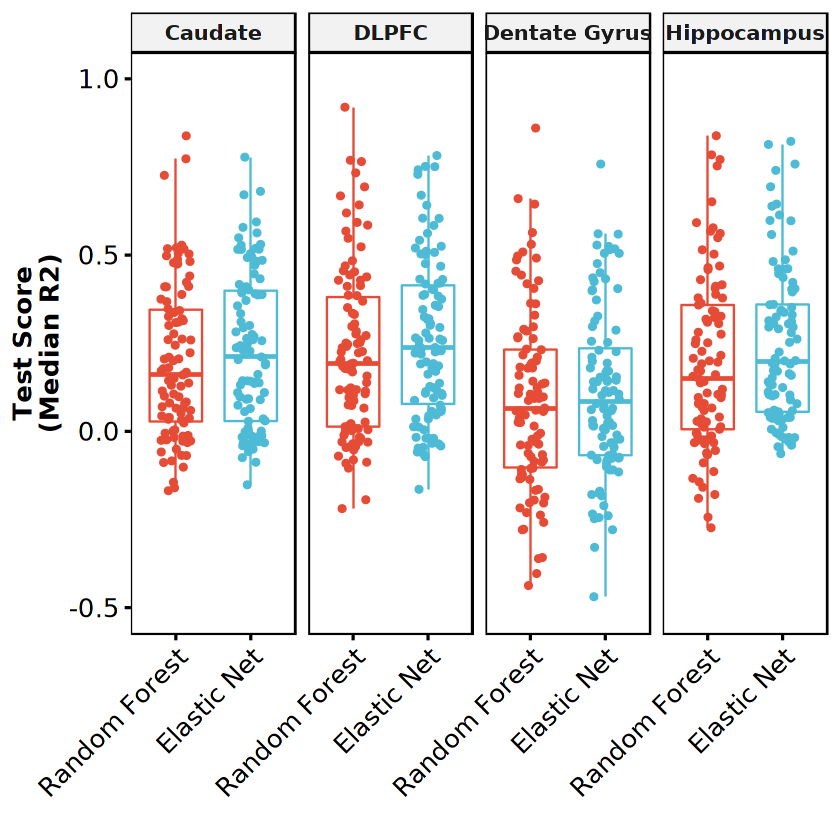

In [30]:
bxp = de100 %>% 
    ggboxplot(x="model", y="Median", color="model", add="jitter", 
              facet.by="tissue", legend="none", palette="npg", 
              ylim=c(-0.5, 1), ylab="Test Score\n(Median R2)", 
              xlab="", ncol=4, panel.labs.font=list(face='bold'), 
              ggtheme=theme_pubr(base_size=15, border=TRUE)) + 
    rotate_x_text(45) + font("xy.title", face="bold")
save_plot(bxp, "summary_boxplots_r2_top100", 9, 4)
bxp

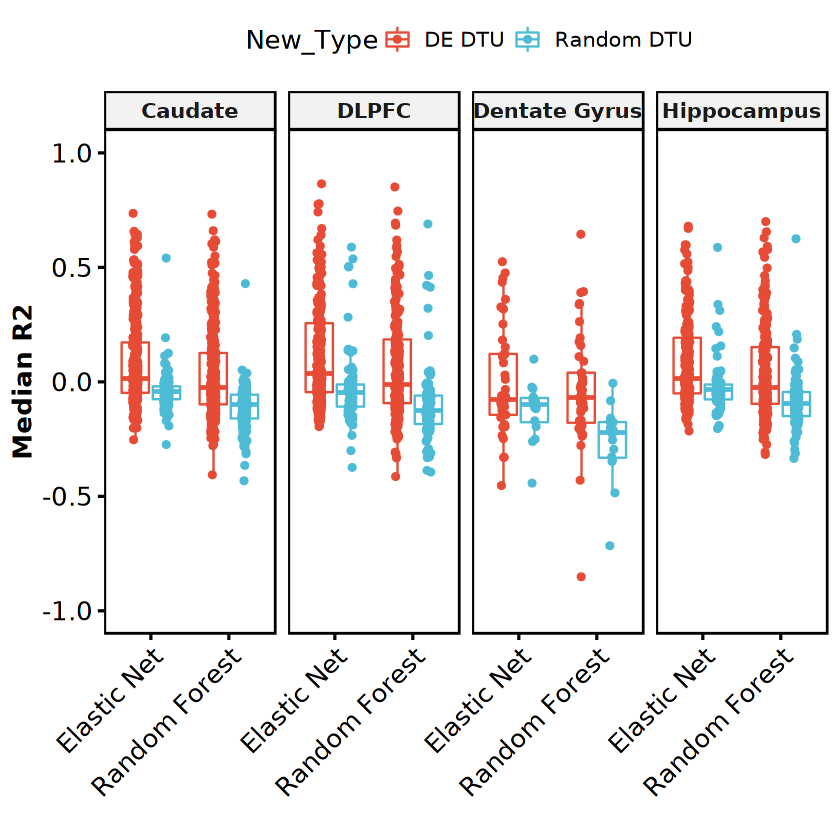

In [16]:
bxp = df %>% filter(DTU == "DTU") %>%
    ggboxplot(x="model", y="Median", color="New_Type", add="jitter", 
                 facet.by="tissue", palette="npg", ylim=c(-1, 1), 
                 ylab="Median R2", xlab="", ncol=4,
                 panel.labs.font=list(face='bold'), 
                 ggtheme=theme_pubr(base_size=15, border=TRUE)) + 
    rotate_x_text(45) + font("xy.title", face="bold")
save_plot(bxp, "summary_boxplots_r2_byType_dtu", 10, 5)
bxp

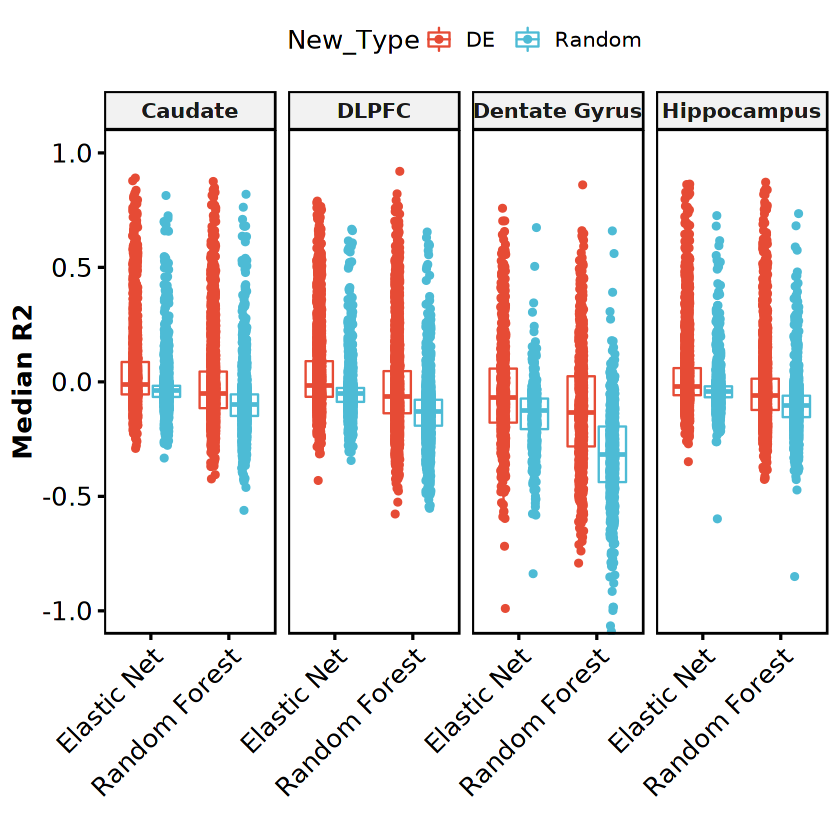

In [17]:
bxp = df %>% filter(New_Type %in% c("DE ", "Random ")) %>%
    ggboxplot(x="model", y="Median", color="New_Type", add="jitter", 
                 facet.by="tissue", palette="npg", ylim=c(-1, 1), 
                 ylab="Median R2", xlab="", ncol=4,
                 panel.labs.font=list(face='bold'), 
                 ggtheme=theme_pubr(base_size=15, border=TRUE)) + 
    rotate_x_text(45) + font("xy.title", face="bold")
save_plot(bxp, "summary_boxplots_r2_byType_de", 10, 5)
bxp

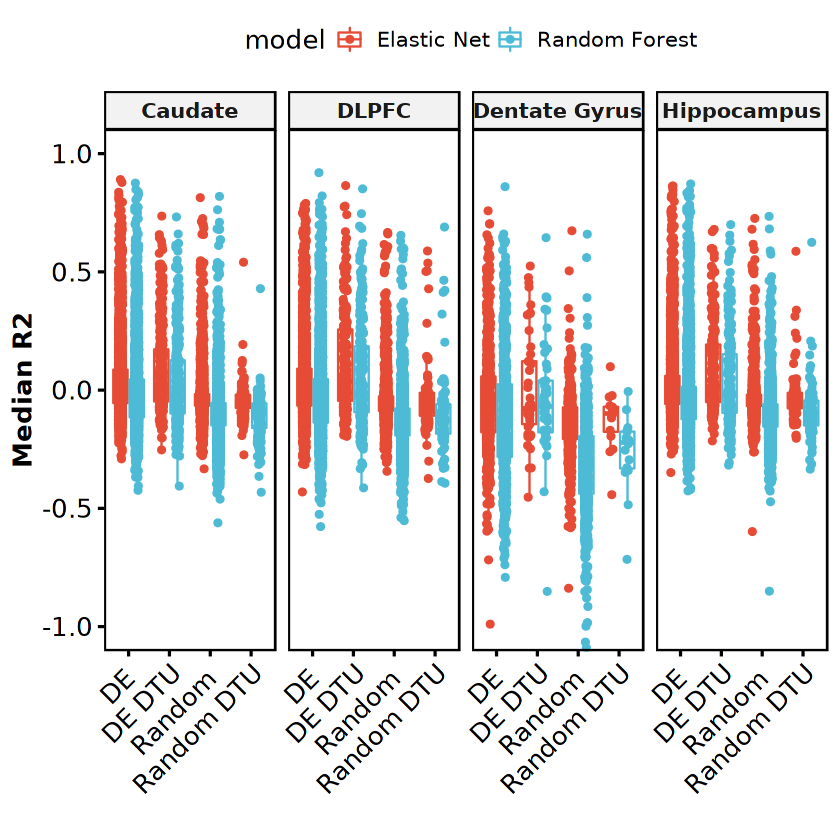

In [18]:
bxp = df %>% ggboxplot(x="New_Type", y="Median", color="model", add="jitter", 
                 facet.by="tissue", palette="npg", ylim=c(-1, 1), 
                 ylab="Median R2", xlab="", ncol=4,
                 panel.labs.font=list(face='bold'), 
                 ggtheme=theme_pubr(base_size=15, border=TRUE)) + 
    rotate_x_text(45) + font("xy.title", face="bold")
save_plot(bxp, "summary_boxplots_r2_byModel", 10, 5)
bxp

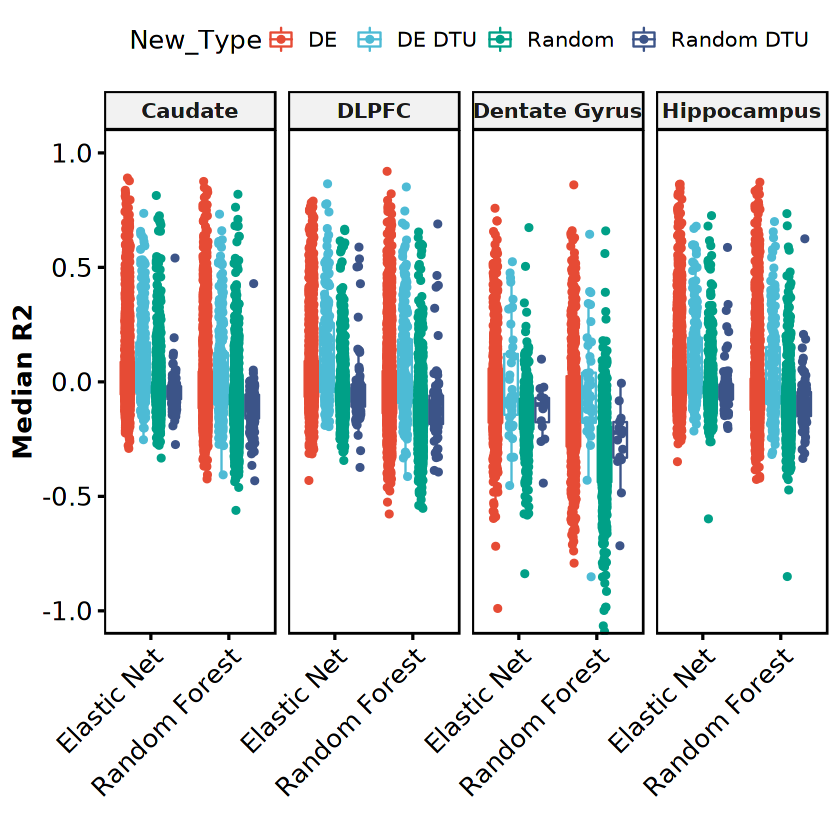

In [19]:
bxp = df %>% ggboxplot(x="model", y="Median", color="New_Type", add="jitter", 
                 facet.by="tissue", palette="npg", ylim=c(-1, 1), 
                 ylab="Median R2", xlab="", ncol=4,
                 panel.labs.font=list(face='bold'), 
                 ggtheme=theme_pubr(base_size=15, border=TRUE)) + 
    rotate_x_text(45) + font("xy.title", face="bold")
save_plot(bxp, "summary_boxplots_r2_byType", 10, 5)
bxp

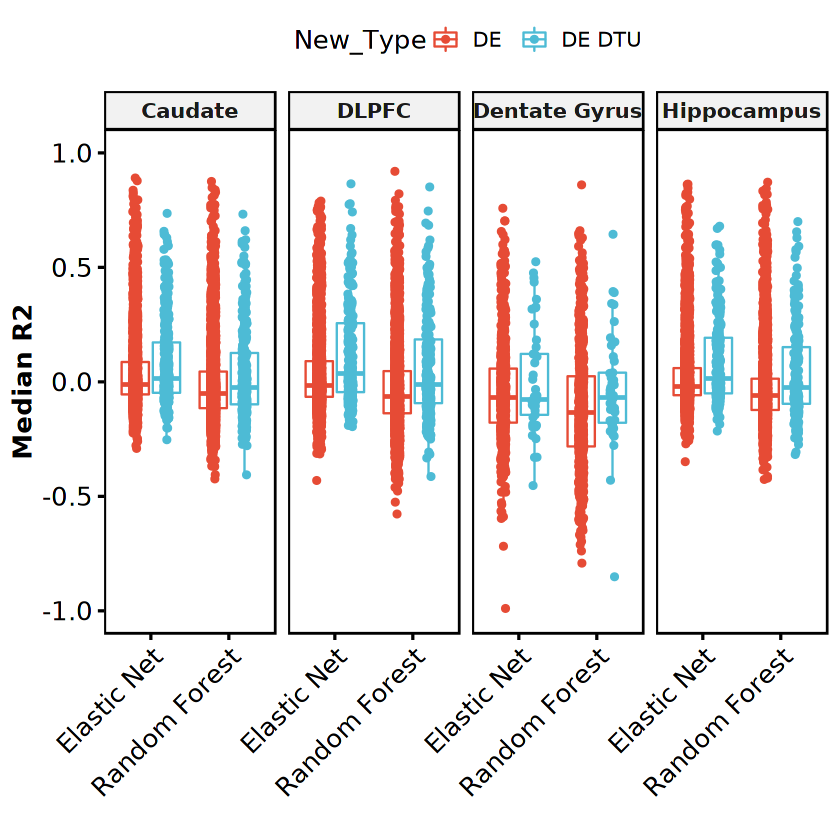

In [20]:
bxp = df %>% filter(Type == "DE") %>%
    ggboxplot(x="model", y="Median", color="New_Type", add="jitter", 
                 facet.by="tissue", palette="npg", ylim=c(-1, 1), 
                 ylab="Median R2", xlab="", ncol=4,
                 panel.labs.font=list(face='bold'), 
                 ggtheme=theme_pubr(base_size=15, border=TRUE)) + 
    rotate_x_text(45) + font("xy.title", face="bold")
save_plot(bxp, "summary_boxplots_r2_deg", 10, 5)
bxp

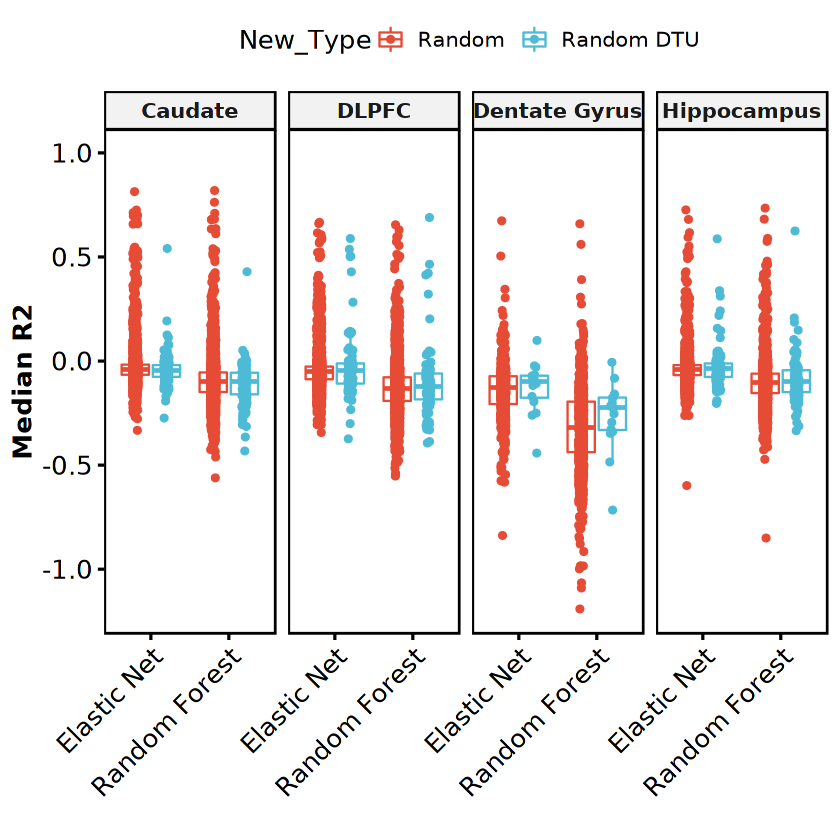

In [21]:
bxp = df %>% filter(Type == "Random") %>%
    ggboxplot(x="model", y="Median", color="New_Type", add="jitter", 
                 facet.by="tissue", palette="npg", ylim=c(-1.2, 1), 
                 ylab="Median R2", xlab="", ncol=4,
                 panel.labs.font=list(face='bold'), 
                 ggtheme=theme_pubr(base_size=15, border=TRUE)) + 
    rotate_x_text(45) + font("xy.title", face="bold")
save_plot(bxp, "summary_boxplots_r2_random", 10, 5)
bxp

#### Distribution

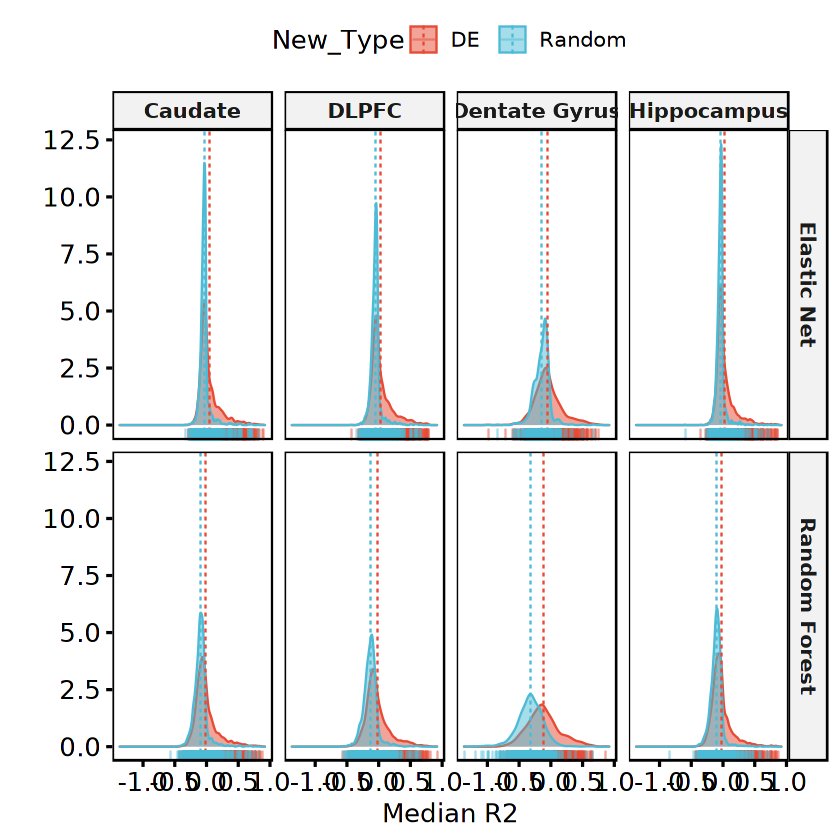

In [22]:
freq = df %>%  filter(New_Type %in% c("DE ", "Random ")) %>%
    ggdensity(x = "Median", add = "mean", rug = TRUE,
              color = "New_Type", fill = "New_Type", palette="npg", 
              facet.by=c("model", "tissue"), xlab="Median R2", 
              panel.labs.font=list(face='bold'), ylab="",
              ggtheme=theme_pubr(base_size=15, border=TRUE))
save_plot(freq, "summary_distribution_r2_de", 10, 5)
freq

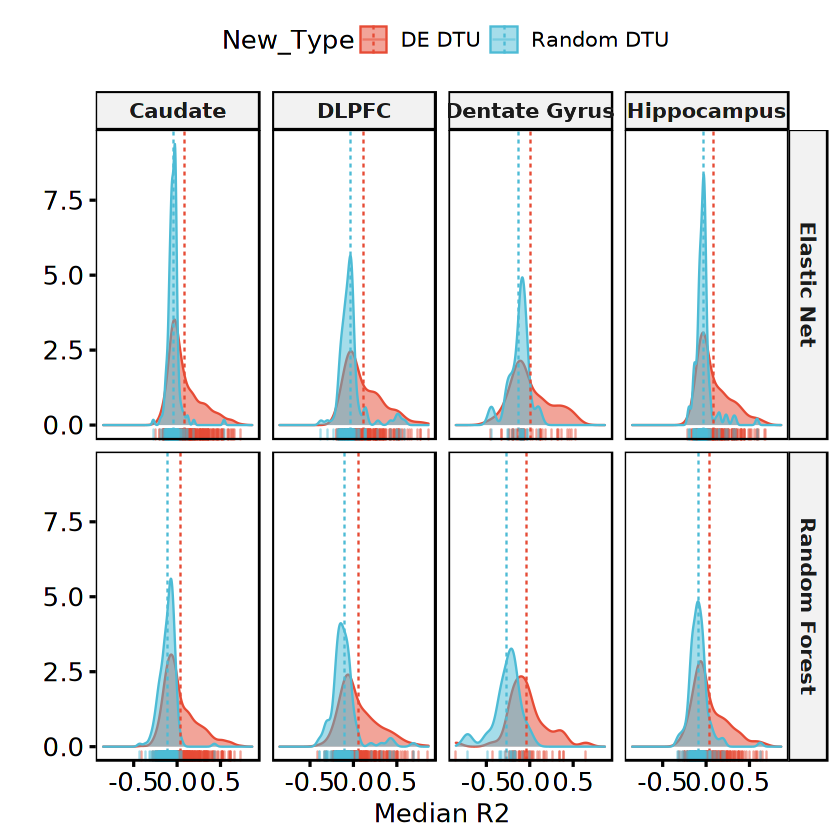

In [23]:
freq = df %>%  filter(DTU == "DTU") %>%
    ggdensity(x = "Median", add = "mean", rug = TRUE,
              color = "New_Type", fill = "New_Type", palette="npg", 
              facet.by=c("model", "tissue"), xlab="Median R2", 
              panel.labs.font=list(face='bold'), ylab="",
              ggtheme=theme_pubr(base_size=15, border=TRUE))
save_plot(freq, "summary_distribution_r2_dtu", 10, 5)
freq

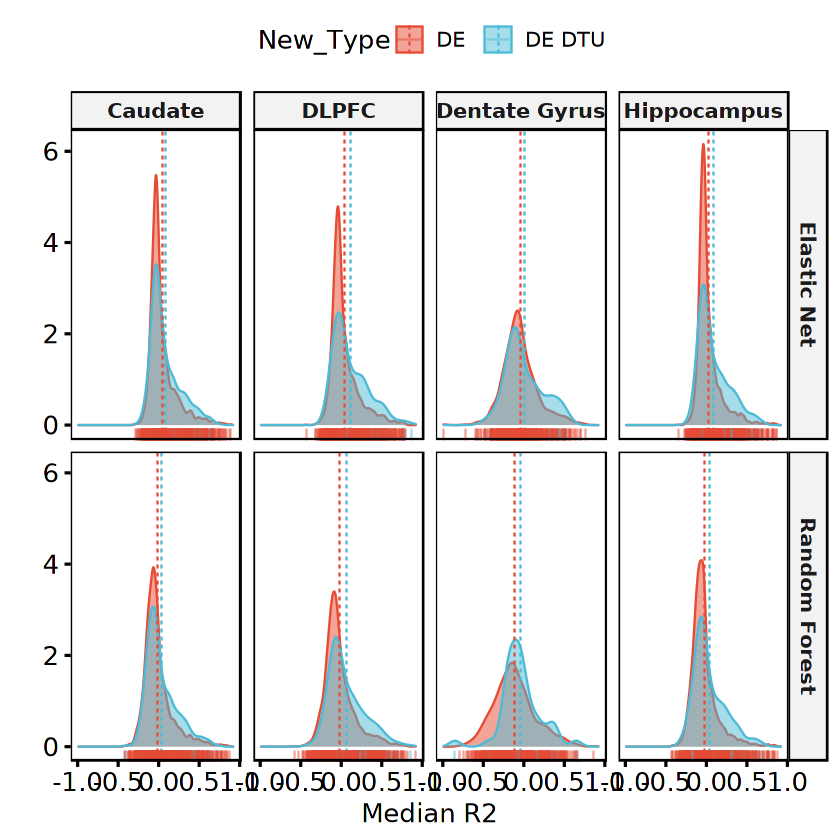

In [24]:
freq = df %>% filter(Type == "DE") %>%
    ggdensity(x = "Median", add = "mean", rug = TRUE,
              color = "New_Type", fill = "New_Type", palette="npg", 
              facet.by=c("model", "tissue"), xlab="Median R2", 
              panel.labs.font=list(face='bold'), ylab="",
              ggtheme=theme_pubr(base_size=15, border=TRUE))
save_plot(freq, "summary_distribution_r2_degs", 10, 5)
freq

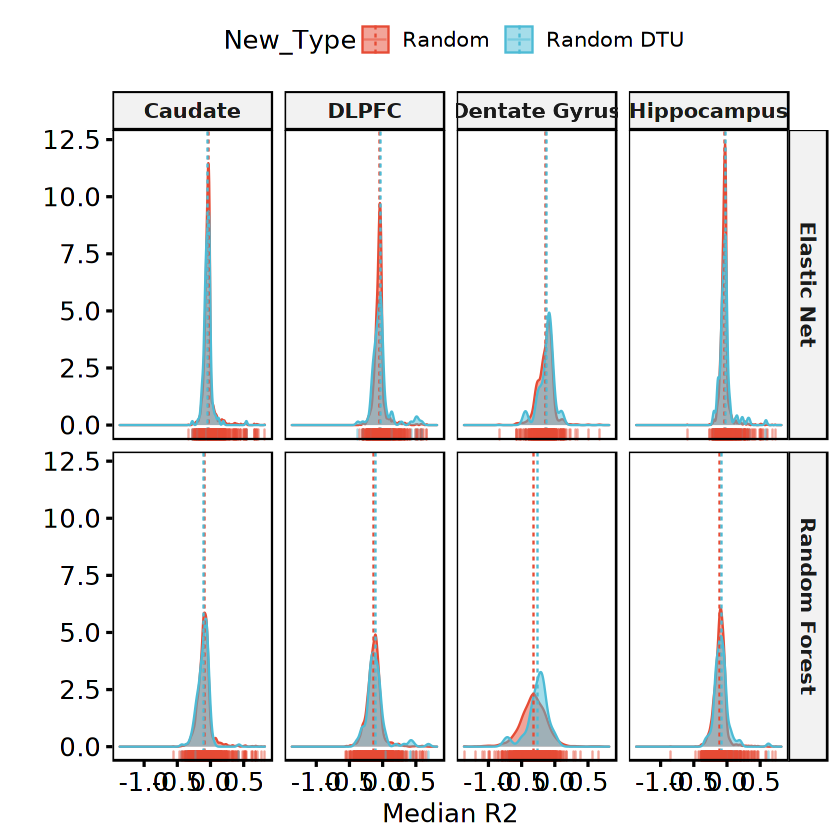

In [25]:
freq = df %>% filter(Type == "Random") %>%
    ggdensity(x = "Median", add = "mean", rug = TRUE,
              color = "New_Type", fill = "New_Type", palette="npg", 
              facet.by=c("model", "tissue"), xlab="Median R2", 
              panel.labs.font=list(face='bold'), ylab="",
              ggtheme=theme_pubr(base_size=15, border=TRUE))
save_plot(freq, "summary_distribution_r2_random", 10, 5)
freq

## Explained variance with partial r2

### Load data

In [31]:
de2 = data.table::fread("../../de_genes/partial_r2/rf_partial_r2_metrics.tsv") %>%
    mutate(Type = "DE") %>% left_join(degs, by=c("Tissue"="tissue", "Geneid"="Feature")) %>% 
    as.data.frame %>% mutate(New_Type = paste(Type, replace_na(DTU, ""))) %>%
    mutate_if(is.character, as.factor)
de2 %>% head(2)

,Geneid,N_Features,Partial_R2,Full_R2,Reduced_R2,Tissue,Type,ensemblID,gene_name,DTU,New_Type
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,ENSG00000003249.13,33,0.24367297,171.4880,226.7379,Caudate,DE,NA,NA,NA,DE
2,ENSG00000003509.15,2,0.01313991,225.4272,228.4288,Caudate,DE,NA,NA,NA,DE


In [32]:
de100_v2 = data.table::fread("../../de_genes/partial_r2/rf_partial_r2_metrics.tsv") %>%
    mutate(Type = "DE") %>% inner_join(top100, by=c("Tissue"="tissue", "Geneid"="Feature"))
de100_v2 %>% dim
de100_v2 %>% head(2)

[1] 382   9

Geneid,N_Features,Partial_R2,Full_R2,Reduced_R2,Tissue,Type,ensemblID,gene_name
<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
ENSG00000014824.13,3,0.09679049,167.7481,185.7245,Caudate,DE,ENSG00000014824,SLC30A9
ENSG00000034053.14,31,0.13785014,169.7030,196.8370,Caudate,DE,ENSG00000034053,APBA2


In [33]:
rand2 = data.table::fread("../../random_genes/partial_r2/rf_partial_r2_metrics.tsv") %>%
    mutate(Type = "Random") %>% left_join(random, by=c("Tissue"="tissue", "Geneid"="Feature")) %>% 
    as.data.frame %>% mutate(New_Type = paste(Type, replace_na(DTU, ""))) %>%
    mutate_if(is.character, as.factor)
rand2 %>% head(2)

,Geneid,N_Features,Partial_R2,Full_R2,Reduced_R2,Tissue,Type,ensemblID,gene_name,DTU,New_Type
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,ENSG00000001084.10,18,0.173657975,196.5602,237.8679,Caudate,Random,NA,NA,NA,Random
2,ENSG00000001630.15,2,0.006767595,233.4418,235.0324,Caudate,Random,NA,NA,NA,Random


In [34]:
df2 = bind_rows(de2, rand2)
df2 %>% head(2)

,Geneid,N_Features,Partial_R2,Full_R2,Reduced_R2,Tissue,Type,ensemblID,gene_name,DTU,New_Type
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,ENSG00000003249.13,33,0.24367297,171.4880,226.7379,Caudate,DE,NA,NA,NA,DE
2,ENSG00000003509.15,2,0.01313991,225.4272,228.4288,Caudate,DE,NA,NA,NA,DE


### Summary

In [35]:
df2 %>% group_by(Tissue, Type) %>% 
    summarise(Mean=mean(Partial_R2), Median=median(Partial_R2), 
              Std=sd(Partial_R2), .groups = "keep") 

Tissue,Type,Mean,Median,Std
<fct>,<fct>,<dbl>,<dbl>,<dbl>
Caudate,DE,0.12115161,0.06459714,0.14915843
Caudate,Random,0.05462609,0.01699683,0.09628326
DLPFC,DE,0.12918919,0.07083068,0.15498073
DLPFC,Random,0.05820650,0.02022916,0.09648807
Dentate Gyrus,DE,0.20111520,0.14450007,0.18599017
Dentate Gyrus,Random,0.12287941,0.07247299,0.14869899
Hippocampus,DE,0.10386637,0.04787038,0.14271472
Hippocampus,Random,0.04587896,0.01430467,0.08136296


In [36]:
de100_v2 %>% group_by(Tissue) %>% 
    summarise(Mean=mean(Partial_R2), Median=median(Partial_R2), 
              Std=sd(Partial_R2), .groups = "keep")

Tissue,Mean,Median,Std
<chr>,<dbl>,<dbl>,<dbl>
Caudate,0.2041160,0.1399830,0.1837352
DLPFC,0.2456374,0.2091248,0.1972761
Dentate Gyrus,0.2727508,0.2280635,0.2120016
Hippocampus,0.2156581,0.1593486,0.1900711


In [37]:
df2 %>% group_by(Tissue, New_Type) %>% 
    summarise(Mean=mean(Partial_R2), Median=median(Partial_R2), 
              Std=sd(Partial_R2), .groups = "keep") 

Tissue,New_Type,Mean,Median,Std
<fct>,<fct>,<dbl>,<dbl>,<dbl>
Caudate,DE,0.11714984,0.06256508,0.14628216
Caudate,DE DTU,0.14799147,0.08160512,0.16489588
Caudate,Random,0.05484748,0.01691896,0.09715149
Caudate,Random DTU,0.05096409,0.02011857,0.08074849
DLPFC,DE,0.12382915,0.06713538,0.14951782
DLPFC,DE DTU,0.18373550,0.11131387,0.19450281
DLPFC,Random,0.05714081,0.02007225,0.09325817
DLPFC,Random DTU,0.08482760,0.02604147,0.15528999
Dentate Gyrus,DE,0.19965350,0.14300394,0.18680034


### Significance

In [38]:
## Test if DE genes are significant more predictive than random genes
for(tissue in c("Caudate", "Dentate Gyrus", "DLPFC", "Hippocampus")){
    xx = de2 %>% filter(Tissue == tissue)
    yy = rand2 %>% filter(Tissue == tissue)
    tt = t.test(xx$Partial_R2, yy$Partial_R2, alternative = "greater")$p.value
    print(tt)
}

[1] 8.96649e-86
[1] 1.187035e-19
[1] 1.037743e-85
[1] 7.833267e-76


In [39]:
df2 %>% group_by(Tissue) %>% 
    do(fit = broom::tidy(lm(Partial_R2 ~ Type, data=.))) %>%
    unnest(fit) %>% filter(term != '(Intercept)') %>%
    mutate(p.bonf = p.adjust(p.value, "bonf"))

Tissue,term,estimate,std.error,statistic,p.value,p.bonf
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Caudate,TypeRandom,-0.06652552,0.003348234,-19.868842,5.677769e-85,2.271108e-84
DLPFC,TypeRandom,-0.07098269,0.003557188,-19.954719,1.797423e-85,7.189692e-85
Dentate Gyrus,TypeRandom,-0.07823578,0.008574660,-9.124068,2.200512e-19,8.802046e-19
Hippocampus,TypeRandom,-0.05798741,0.003122240,-18.572373,9.228185e-75,3.691274e-74


In [40]:
df2 %>% filter(Type == "DE") %>% group_by(Tissue) %>% 
    do(fit = broom::tidy(lm(Partial_R2 ~ New_Type, data=.))) %>%
    unnest(fit) %>% filter(term != '(Intercept)') %>%
    mutate(p.bonf = p.adjust(p.value, "bonf"))

Tissue,term,estimate,std.error,statistic,p.value,p.bonf
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Caudate,New_TypeDE DTU,0.03084163,0.008271409,3.7287033,1.961946e-04,7.847783e-04
DLPFC,New_TypeDE DTU,0.05990636,0.010465602,5.7241197,1.156213e-08,4.624854e-08
Dentate Gyrus,New_TypeDE DTU,0.02617462,0.029193712,0.8965843,3.702217e-01,1.000000e+00
Hippocampus,New_TypeDE DTU,0.05496215,0.010050855,5.4684055,4.935523e-08,1.974209e-07


In [41]:
df2 %>% filter(Type == "Random") %>% group_by(Tissue) %>% 
    do(fit = broom::tidy(lm(Partial_R2 ~ New_Type, data=.))) %>%
    unnest(fit) %>% filter(term != '(Intercept)') %>%
    mutate(p.bonf = p.adjust(p.value, "bonf"))

Tissue,term,estimate,std.error,statistic,p.value,p.bonf
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Caudate,New_TypeRandom DTU,-0.003883392,0.007864253,-0.4938030,0.621484224,1.00000000
DLPFC,New_TypeRandom DTU,0.027686784,0.009778135,2.8314994,0.004668366,0.01867346
Dentate Gyrus,New_TypeRandom DTU,-0.029953185,0.037574957,-0.7971582,0.425604886,1.00000000
Hippocampus,New_TypeRandom DTU,0.017885218,0.008090846,2.2105498,0.027149271,0.10859708


### Plot

#### Boxplots

In [ ]:
bxp = de100_v2 %>% 
    ggboxplot(x="Tissue", y="Partial_R2", fill="Tissue", add="jitter", 
              palette="npg", legend="none", ylim=c(0, 1), xlab="", ncol=4, 
              ylab="Explained Variance", panel.labs.font=list(face='bold'), 
              ggtheme=theme_pubr(base_size=15, border=TRUE)) + 
    rotate_x_text(45) + font("xy.title", face="bold")
save_plot(bxp, "explained_variance_boxplots_top100", 6, 5)
bxp

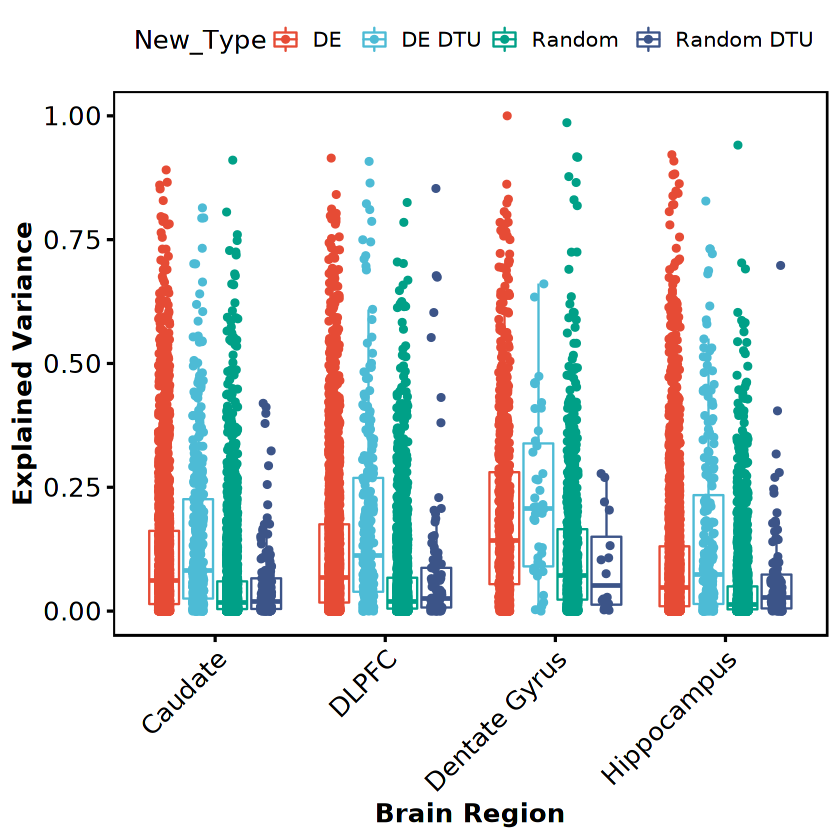

In [37]:
bxp = df2 %>% #filter(Type == "DE") %>%
    ggboxplot(x="Tissue", y="Partial_R2", color="New_Type", add="jitter", 
              palette="npg", ylim=c(0, 1), ylab="Explained Variance", 
              xlab="Brain Region", ncol=4,
              ggtheme=theme_pubr(base_size=15, border=TRUE)) + 
    rotate_x_text(45) + font("xy.title", face="bold")
save_plot(bxp, "explained_variance_boxplot_all", 7, 5.5)
bxp

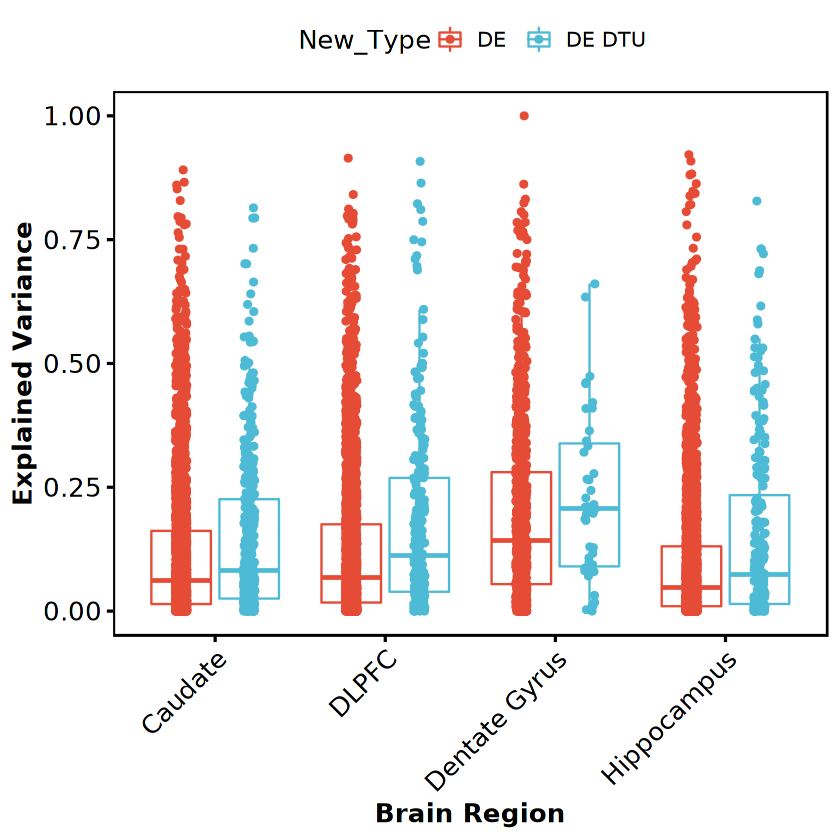

In [38]:
bxp = df2 %>% filter(Type == "DE") %>%
    ggboxplot(x="Tissue", y="Partial_R2", color="New_Type", add="jitter", 
              palette="npg", ylim=c(0, 1), ylab="Explained Variance", 
              xlab="Brain Region", ncol=4,
              ggtheme=theme_pubr(base_size=15, border=TRUE)) + 
    rotate_x_text(45) + font("xy.title", face="bold")
save_plot(bxp, "explained_variance_boxplot_de", 6, 5.5)
bxp

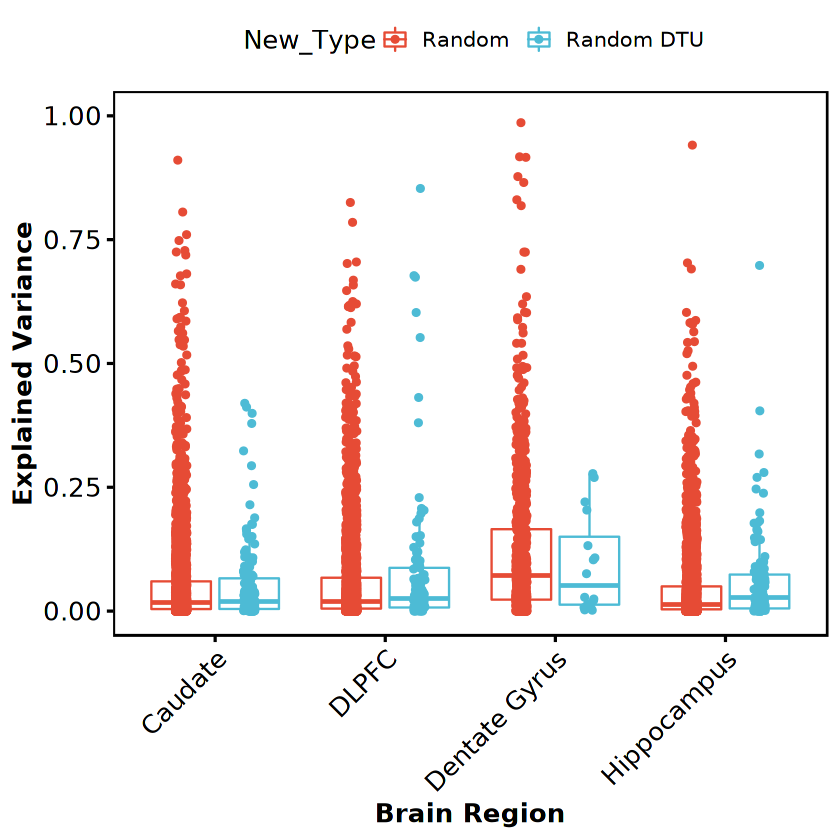

In [39]:
bxp = df2 %>% filter(Type == "Random") %>%
    ggboxplot(x="Tissue", y="Partial_R2", color="New_Type", add="jitter", 
              palette="npg", ylim=c(0, 1), ylab="Explained Variance", 
              xlab="Brain Region", ncol=4,
              ggtheme=theme_pubr(base_size=15, border=TRUE)) + 
    rotate_x_text(45) + font("xy.title", face="bold")
save_plot(bxp, "explained_variance_boxplot_random", 6, 5.5)
bxp

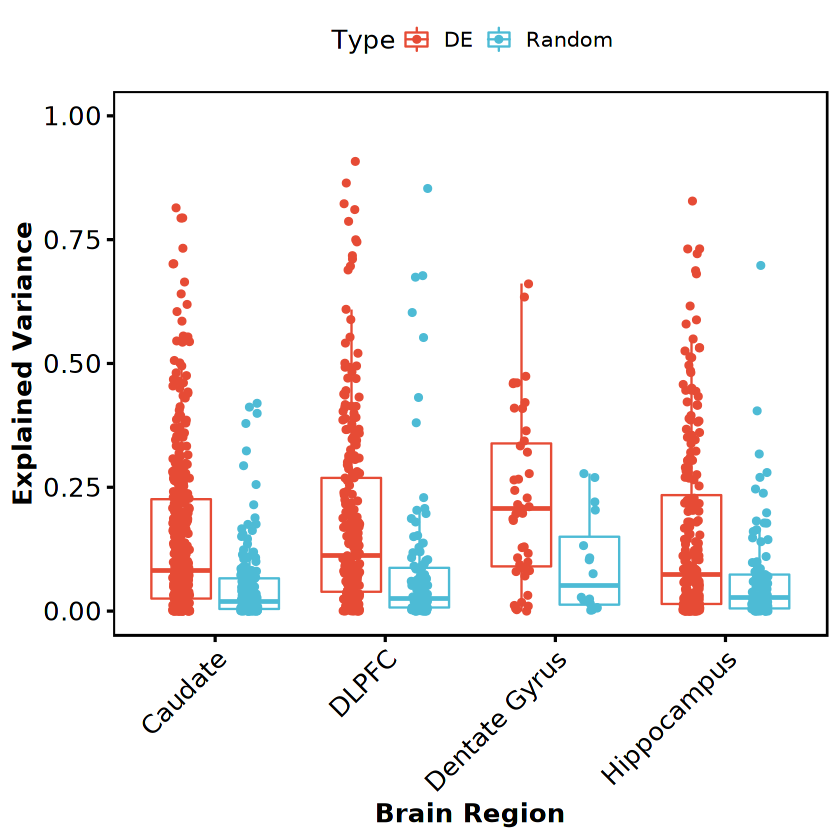

In [40]:
bxp = df2 %>%  filter(DTU == "DTU") %>%
    ggboxplot(x="Tissue", y="Partial_R2", color="Type", add="jitter", 
              palette="npg", ylim=c(0, 1), ylab="Explained Variance", 
              xlab="Brain Region", ncol=4,
              ggtheme=theme_pubr(base_size=15, border=TRUE)) + 
    rotate_x_text(45) + font("xy.title", face="bold")
save_plot(bxp, "explained_variance_boxplot_dtu", 6, 5.5)
bxp

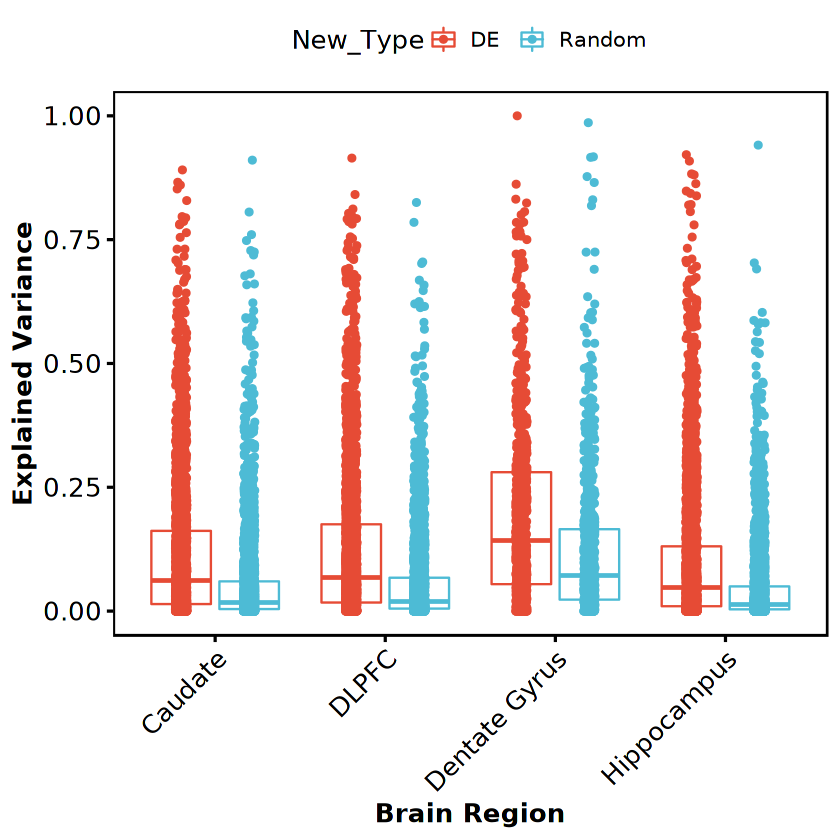

In [41]:
bxp = df2 %>%  filter(New_Type %in% c("DE ", "Random ")) %>%
    ggboxplot(x="Tissue", y="Partial_R2", color="New_Type", add="jitter", 
              palette="npg", ylim=c(0, 1), ylab="Explained Variance", 
              xlab="Brain Region", ncol=4,
              ggtheme=theme_pubr(base_size=15, border=TRUE)) + 
    rotate_x_text(45) + font("xy.title", face="bold")
save_plot(bxp, "explained_variance_boxplot", 6, 5.5)
bxp

#### Distribution

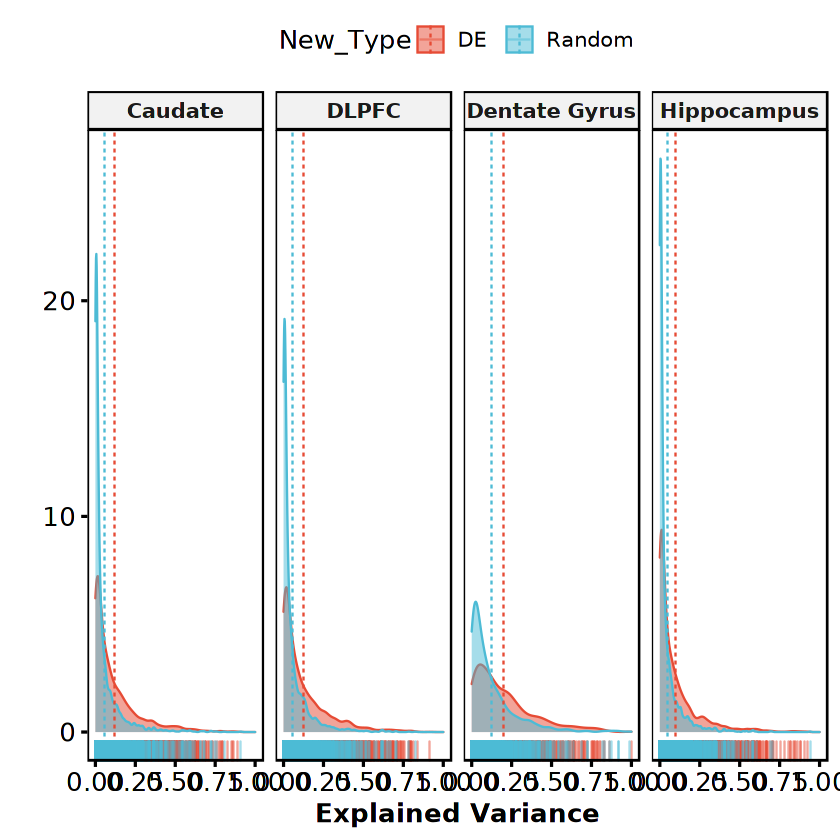

In [42]:
freq = df2 %>%  filter(New_Type %in% c("DE ", "Random ")) %>%
    ggdensity(x = "Partial_R2", add = "mean", rug = TRUE,
              color = "New_Type", fill = "New_Type", palette="npg", 
              facet.by=c("Tissue"), xlab="Explained Variance", 
              panel.labs.font=list(face='bold'), ylab="", ncol=4,
              ggtheme=theme_pubr(base_size=15, border=TRUE)) + 
    font("xy.title", face="bold")
save_plot(freq, "explained_variance_distribution", 10, 4)
freq

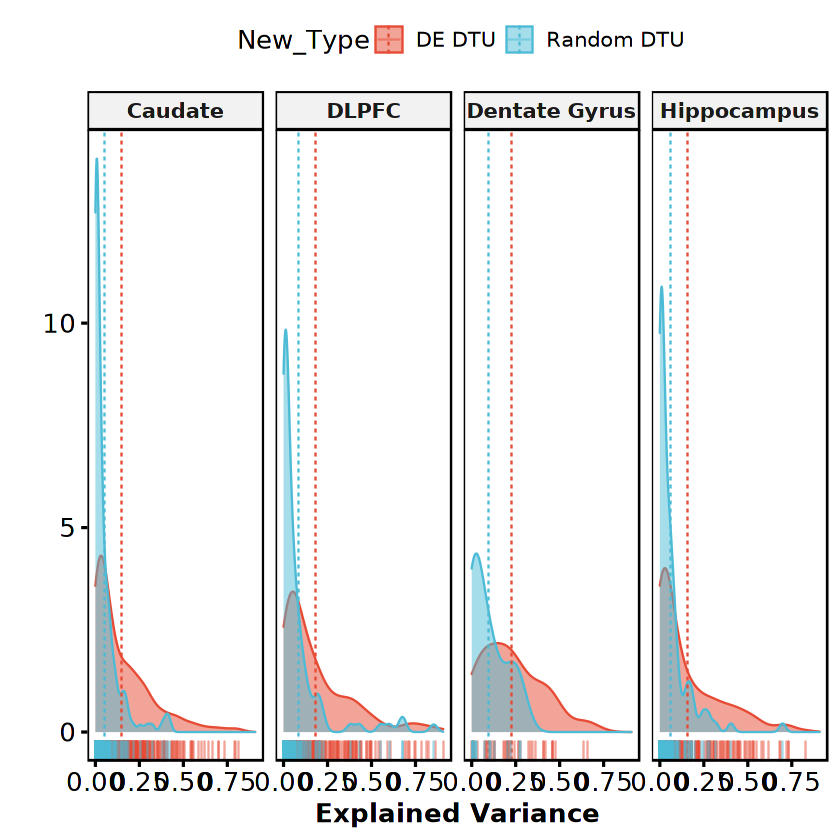

In [43]:
freq = df2 %>%  filter(DTU == "DTU") %>%
    ggdensity(x = "Partial_R2", add = "mean", rug = TRUE,
              color = "New_Type", fill = "New_Type", palette="npg", 
              facet.by=c("Tissue"), xlab="Explained Variance", 
              panel.labs.font=list(face='bold'), ylab="", ncol=4,
              ggtheme=theme_pubr(base_size=15, border=TRUE)) + 
    font("xy.title", face="bold")
save_plot(freq, "explained_variance_distribution_dtu", 10, 4)
freq

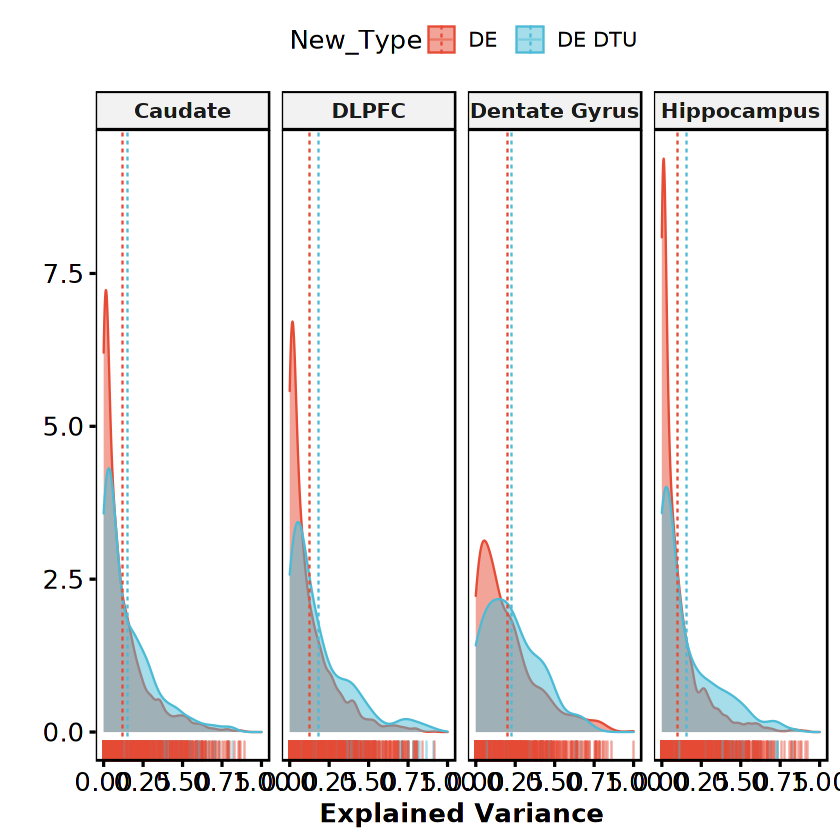

In [45]:
freq = df2 %>% filter(Type == "DE") %>%
    ggdensity(x = "Partial_R2", add = "mean", rug = TRUE,
              color = "New_Type", fill = "New_Type", palette="npg", 
              facet.by=c("Tissue"), xlab="Explained Variance", 
              panel.labs.font=list(face='bold'), ylab="", ncol=4,
              ggtheme=theme_pubr(base_size=15, border=TRUE)) + 
    font("xy.title", face="bold")
save_plot(freq, "explained_variance_distribution_de", 10, 4)
freq

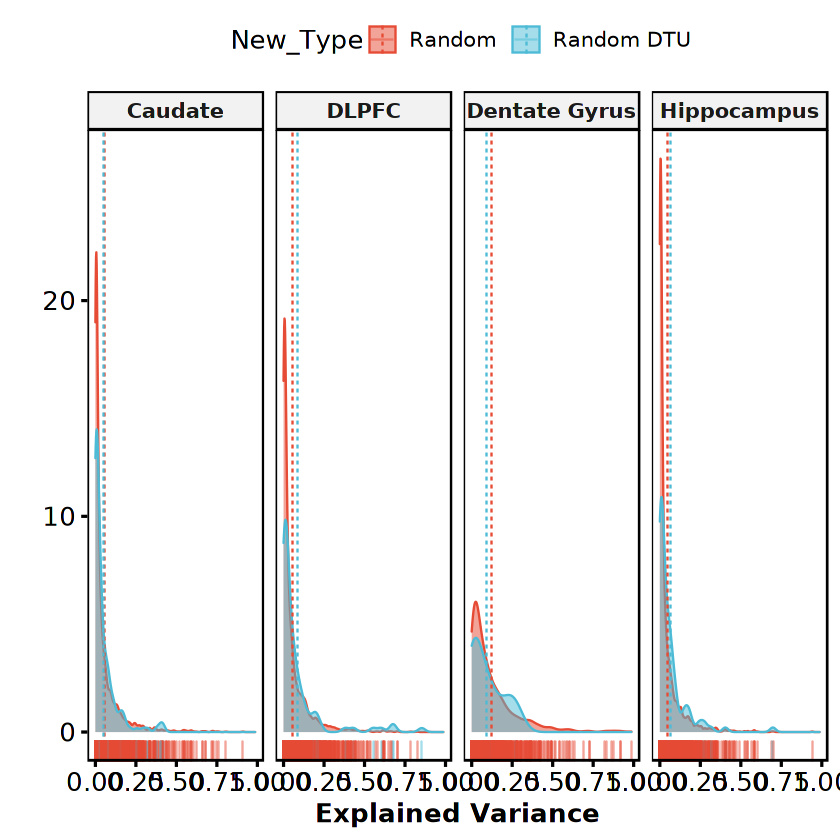

In [46]:
freq = df2 %>% filter(Type == "Random") %>%
    ggdensity(x = "Partial_R2", add = "mean", rug = TRUE,
              color = "New_Type", fill = "New_Type", palette="npg", 
              facet.by=c("Tissue"), xlab="Explained Variance", 
              panel.labs.font=list(face='bold'), ylab="", ncol=4,
              ggtheme=theme_pubr(base_size=15, border=TRUE)) + 
    font("xy.title", face="bold")
save_plot(freq, "explained_variance_distribution_random", 10, 4)
freq

## Reproducibility Information

In [ ]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()